In [65]:
# Import comet_ml at the top of your file
# from comet_ml import Experiment

from matplotlib import pyplot as plt
# from matplotlib import style
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import swifter
from sklearn import metrics
import itertools
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras as k
import tensorflow as tf
# import torch
from scipy import stats
import nltk


# Create an experiment with your api key
# experiment = Experiment(
#     api_key="BKac2uRt0FMAlheXf6HClaZhD",
#     project_name="general",
#     workspace="sarthak7034",
# )


In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# torch.cuda.is_available()

In [66]:
nltk.download('stopwords')
stop_words = stopwords.words('english') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/s/sarthak_7034/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# experiment.end()

In [68]:
#Read dataset
data = pd.read_csv("./all_data.csv").drop("Unnamed: 0", axis=1)

In [69]:
def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    # remove stopwords
    tokens = [w for w in tokens if not w in stop_words] 
    #Remove non alphanumerica characters
    words = [word for word in tokens if word.isalpha()]    
    return words

scaler = MinMaxScaler()

In [70]:
#Applying lamdba function to clean text
data['text'] = data.swifter.apply(lambda row: clean_text(row['text']), axis=1)
#Clean title
data['title'] = data.swifter.apply(lambda row: clean_text(row['title']), axis=1)

#Replacing columns with cleaned ones
data = data[data['title'].str.len() >= 1]
data = data[data['text'].str.len() >= 1]


Dask Apply:   0%|          | 0/80 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/80 [00:00<?, ?it/s]

In [71]:
df1 = data.loc[:,['anger','anticipation','disgust','fear','joy','sadness','surprise','trust','negative','positive']]

# Zero Score Dataframe Normalization
MaxMin_df = stats.zscore(df1)
MaxMin_df.head()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
0,-0.024310,0.914206,-0.026906,-0.430022,1.614388,-0.341950,1.602143,0.665949,-0.251048,0.953896
1,-0.312661,-0.431075,-0.488004,-0.587967,-0.461020,-0.450475,-0.098309,-0.579746,-0.540799,-0.494906
2,-0.408779,0.722023,0.126793,-0.272076,0.965823,-0.016373,0.090630,0.428674,-0.202756,0.249073
3,0.167925,0.241565,0.126793,-0.114131,0.317258,0.200678,0.090630,0.784586,0.231872,0.601485
4,-0.793248,0.049382,-0.795402,-0.666940,-0.201594,-0.667526,-0.287249,-0.283152,-0.733967,-0.103338


In [ ]:
#Displaying the new dataset which we will be working with
df2 = data.loc[:,['title','text','type']]

In [ ]:
# Whether any values are missing
# df2.isnull().sum()
# df1.isnull().sum()

In [ ]:
# Merging columns
# df2['content'] = df2['title'] + df2['text']
# df2

type
fake    11731
real     8074
Name: title, dtype: int64


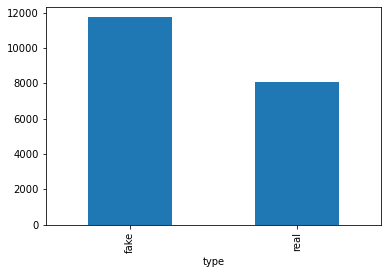

In [73]:
# How many fake and real articles?
print(df2.groupby(['type'])['title'].count())
df2.groupby(['type'])['title'].count().plot(kind="bar")
plt.show()

In [74]:
df2 = df2[df2['text'].map(len) >= 1]
#Reset index
df2 = df2.reset_index().drop("index", axis=1)
df2


,title,text,type
0,"[At, Donald, Trump, Properties, Showcase, Bran...","[They, stood, line, Trump, Tower, sometimes, h...",real
1,"[Trump, Foundation, Tells, New, York, It, Has,...","[Donald, J, Trump, foundation, informed, Attor...",real
2,"[Donald, Trump, Prepares, White, House, Move, ...","[President, Donald, J, Trump, White, House, ou...",real
3,"[Luring, Chinese, Investors, With, Trump, Name...","[An, investment, pitch, new, Texas, hotel, try...",real
4,"[Melania, Barron, Trump, Won, Immediately, Mov...","[President, Donald, J, Trump, wife, Melania, s...",real
...,...,...,...
19800,"[Alabama, Lawmaker, Same, Couples, Don, Deserv...","[Most, conservatives, oppose, marriage, equali...",real
19801,"[GOP, Senator, David, Perdue, Jokes, About, Pr...","[The, freshman, senator, Georgia, quoted, scri...",real
19802,"[State, Department, says, find, emails, Clinto...","[The, State, Department, told, Republican, Nat...",real
19803,"[In, Ethiopia, Obama, seeks, progress, peace, ...","[ADDIS, ABABA, Ethiopia, Obama, convened, meet...",real


In [75]:
model = KeyedVectors.load_word2vec_format("./GoogleNews-vectors-negative300.bin.gz",binary=True)

In [76]:
# Embedding Matrix
embed_mat = np.zeros((50000,300))
for i, e in model.key_to_index.items():
    # embed_mat[model.key_to_index['e']] = model[i]
    embed_mat[model.get_index('e')] = model[i]


In [77]:
# Applying it to the columns (Topic modeling and document similarity analysis)

df2['title'] = df2.apply(lambda r: [model.key_to_index[x] for x in r['title'] if x in model.key_to_index], axis=1)
df2['text'] = df2.apply(lambda r: [model.key_to_index[x] for x in r['text'] if x in model.key_to_index], axis=1)
# df2['content'] = df2.apply(lambda r: [model.key_to_index[x] for x in r['content'] if x in model.key_to_index], axis=1)


In [ ]:
# One-hot encoding
encoder = LabelBinarizer().fit(list(df2['type']))
df2['type'] = df2.swifter.apply(lambda r: encoder.transform([r['type']])[0], axis=1)

In [79]:
def pad_array(array, token_len):
    diff_token = token_len - len(array)
    if(diff_token < 0):
        array = array[:token_len] #Truncate
    else:
        #Pad
        array += [0]*diff_token 
        
    return array 

# tokens_numbers_text = df2.swifter.apply(lambda row: len(row['text']), axis = 1)
# max_tokens_text = int(np.mean(tokens_numbers_text) + 2 * np.std(tokens_numbers_text))

# tokens_numbers_title = df2.swifter.apply(lambda row: len(row['title']), axis = 1)
# max_tokens_title = int(np.mean(tokens_numbers_title) + 2 * np.std(tokens_numbers_title))
# print(max_tokens_text,max_tokens_title)    

# Check the highest length of text and title:
max_tokens_text = 13000
max_tokens_title = 48

df3 = df2.loc[:,['title','text','type']]


In [103]:
# df3['text'] = df2.swifter.apply(lambda r: pad_array(r['text'], max_tokens_text) , axis=1)
# df3['title'] = df2.swifter.apply(lambda r: pad_array(r['title'], max_tokens_title) , axis=1)


df3['text'] = list(pad_sequences((df2['text']), maxlen=max_tokens_text,padding='post'))
df3['title'] = list(pad_sequences(df2['title'], maxlen=max_tokens_title,padding='post'))

In [105]:
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
    df3[['text', 'title']], df3['type'], test_size=0.2, random_state=42)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)
 

train_fit = [np.asarray(X_train['title'].tolist()), 
             np.asarray(X_train['text'].tolist())]

valid_fit = [np.asarray(X_valid['title'].tolist()), 
             np.asarray(X_valid['text'].tolist())]

test_fit = [np.asarray(X_test['title'].tolist()), 
             np.asarray(X_test['text']  .tolist())]    


In [106]:
#input_title
title_input = k.layers.Input(shape=(max_tokens_title,), name='title_input')
inp = k.layers.Embedding(output_dim=300, input_dim=50000, trainable=False, name='embed_title')(title_input)

#Added
x = k.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
x = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
x = k.layers.Flatten()(x)
x = k.layers.Dense(50, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

#input_Title
text_input = k.layers.Input(shape=(max_tokens_text,), name='text_input')
inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, trainable=False, name='embed_text')(text_input)
x2 = k.layers.Conv1D(filters = 40, kernel_size = 16, strides = 2, activation='relu', name='Conv1Text')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool1Text')(x2)

#Added
x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu', name='Conv2Text')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool2Text')(x2)
x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2', name='Dense1Text')(x2)


#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(1, activation='sigmoid')(x)


#Build model
model = k.models.Model(inputs=[title_input, text_input], outputs=[out])
model.compile(k.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        [(None, 48)]         0                                            
__________________________________________________________________________________________________
text_input (InputLayer)         [(None, 13000)]      0                                            
__________________________________________________________________________________________________
embed_title (Embedding)         (None, 48, 300)      15000000    title_input[0][0]                
__________________________________________________________________________________________________
embed_text (Embedding)          (None, 13000, 300)   15000000    text_input[0][0]                 
____________________________________________________________________________________________

In [107]:
hist = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=128, epochs=20,
        callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.1)], validation_data=(valid_fit, np.array(y_valid.tolist())))

Epoch 1/20


InvalidArgumentError:  indices[59,2] = 75042 is not in [0, 50000)
	 [[node model_2/embed_title/embedding_lookup (defined at tmp/ipykernel_18119/2540345468.py:1) ]] [Op:__inference_train_function_2380]

Errors may have originated from an input operation.
Input Source operations connected to node model_2/embed_title/embedding_lookup:
 model_2/embed_title/embedding_lookup/1778 (defined at home/users/s/sarthak_7034/miniconda3/lib/python3.9/contextlib.py:119)

Function call stack:
train_function


In [ ]:
# # Confusion Matrix of SVM
# cm = metrics.confusion_matrix(y_test, prediction)
# plot_confusion_matrix(cm, classes=['Fake', 'Real'])